The notebook focuses on leveraging the Vision Transformer (ViT) architecture for the classification of CT scans by fine-tuning the model.

Dataset: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Features, ClassLabel, Value, Dataset
from datasets import load_dataset
import os
import io
from PIL import Image
import random
NUM_WORKERS = os.cpu_count()
print(NUM_WORKERS)

import torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.cuda.is_available())

from sklearn.model_selection import train_test_split

import torchvision
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

4
True


In [10]:
# Load the dataset
ds = load_dataset(
    'imagefolder', 
    data_dir='/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', 
    split='train',
)

Resolving data files:   0%|          | 0/12446 [00:00<?, ?it/s]

In [11]:
print(ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 12446
})


In [12]:
def transforms(examples):
    examples["pixel_values"] = [image.convert("RGB").resize((224,224)) for image in examples["image"]]
    return examples

In [13]:
ds = ds.map(transforms, remove_columns=["image"], batched=True)
ds

  0%|          | 0/13 [00:00<?, ?ba/s]

Dataset({
    features: ['label', 'pixel_values'],
    num_rows: 12446
})

In [14]:
# Split the dataset
train_test_split = ds.train_test_split(test_size=0.1)

# Now you have train_dataset and test_dataset
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [15]:
print(ds.features)

{'label': ClassLabel(num_classes=4, names=['Cyst', 'Normal', 'Stone', 'Tumor'], id=None), 'pixel_values': Image(decode=True, id=None)}


{'label': 1, 'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7D40143ED9C0>}


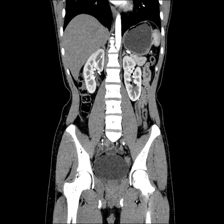

In [16]:
# Consider an example
example = train_dataset[0]
print(example)
img = example['pixel_values']
img

In [17]:
# Lets  look at the format of labels
labels = ds.features['label']
print(labels)
print(labels.int2str(example['label']))

ClassLabel(num_classes=4, names=['Cyst', 'Normal', 'Stone', 'Tumor'], id=None)
Normal


In [18]:
# Load the ViT
from transformers import ViTFeatureExtractor, ViTForImageClassification

extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

2024-04-08 21:17:41.996929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 21:17:41.997049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 21:17:42.136488: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [19]:
img_after_ext = extractor(img, return_tensors='pt')
print(img_after_ext['pixel_values'])

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])


In [20]:
def single_img_processor(img_data):
    img_inputs = extractor(img_data['pixel_values'], return_tensors='pt')
    img_inputs['label'] = img_data['label']
    return img_inputs

In [21]:
single_img_processor(img_data=example)

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]]), 'label': 1}

In [22]:
# Processor for batch images
def batch_processor(img_batch_data):
    batch_inputs = extractor([x for x in img_batch_data['pixel_values']], return_tensors='pt')
    batch_inputs['label'] = img_batch_data['label']
    return batch_inputs

In [23]:
# Try the `batch_processor`
img_batch = train_dataset[:2]
print(img_batch)

# Feed into my processor
out = batch_processor(img_batch_data=img_batch)
print(out)

{'label': [1, 2], 'pixel_values': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7D3F8E021AB0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7D3F8E0200A0>]}
{'pixel_values': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0

In [24]:
# Apply the processor into my dataset
ex_train_data = train_dataset.with_transform(batch_processor)
ex_test_data = test_dataset.with_transform(batch_processor)

In [25]:
print(ex_train_data)

Dataset({
    features: ['label', 'pixel_values'],
    num_rows: 11201
})


In [27]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'label': torch.tensor([x['label'] for x in batch])
    }

In [28]:
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [38]:
# Load the ViT model 
labels = train_dataset.features['label'].names

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

model = model.to('cuda')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# training model
from transformers import Trainer, TrainingArguments

# Define Trainer arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # Total number of training epochs
    per_device_train_batch_size=32,  # Batch size per device during training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=3,
)

# Define Trainer
trainer = Trainer(
    model=model,                         # The instantiated ViT model to be trained
    args=training_args,                  # Training arguments
    train_dataset=ex_train_data,         # Training dataset
    eval_dataset=ex_test_data            # Evaluation dataset
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [40]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,0.000400,0.000356


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=528, training_loss=0.22247333930819435, metrics={'train_runtime': 918.4385, 'train_samples_per_second': 36.587, 'train_steps_per_second': 0.575, 'total_flos': 2.6040100040184545e+18, 'train_loss': 0.22247333930819435, 'epoch': 3.0})

In [41]:
metrics = trainer.evaluate(ex_test_data)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_loss               =     0.0003
  eval_runtime            = 0:00:18.50
  eval_samples_per_second =     67.269
  eval_steps_per_second   =       0.54
